In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
import os

# Define paths to the data on your Google Drive
base_path = '/kaggle/input/sector13'

# Load the .npy files and their labels
def load_data_and_labels(galaxy_folder, star_folder, galaxy_csv, star_csv):
    # Load metadata from CSV files to ensure correct labeling
    galaxy_metadata = pd.read_csv(galaxy_csv,skiprows=1)
    star_metadata = pd.read_csv(star_csv, skiprows=1)

    images = []
    labels = []  # 0 for star, 1 for galaxy

    def extract_objid(filename):
        return filename.split('_')[-1].split('.')[0]

    for file in os.listdir(galaxy_folder):
        if file.endswith('.npy'):
            objid = extract_objid(file)
            if any(galaxy_metadata['objid'].astype(str) == objid):
                img = np.load(os.path.join(galaxy_folder, file))
                images.append(img)
                labels.append(1)

    for file in os.listdir(star_folder):
        if file.endswith('.npy'):
            objid = extract_objid(file)
            if any(star_metadata['objid'].astype(str) == objid):
                img = np.load(os.path.join(star_folder, file))
                images.append(img)
                labels.append(0)

    return np.array(images), np.array(labels)

# Update the paths
galaxy_folder = os.path.join(base_path, 'Augmented_Galaxy_Images/Augmented_Galaxy_Images')
star_folder = os.path.join(base_path, 'Augmented_Star_Images/Augmented_Star_Images')
galaxy_csv = os.path.join(base_path, 'galaxy_s13.csv')
star_csv = os.path.join(base_path, 'star_s13.csv')

images, labels = load_data_and_labels(galaxy_folder, star_folder, galaxy_csv, star_csv)
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Define the CNN model
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(45, 45, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification layer 
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Ensure labels are in the correct shape for binary_crossentropy
y_train = y_train.flatten()
y_val = y_val.flatten()

# Train the CNN
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    batch_size=32
)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 43, 43, 32)        1472      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 21, 21, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 19, 19, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 9, 9, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 3, 3, 128)        

63/63 [==============================] - 1s 16ms/step - loss: 0.1868 - accuracy: 0.9450
Validation Accuracy:  0.9449999928474426
63/63 [==============================] - 1s 16ms/step
Confusion Matrix:
[[930  58]
 [ 52 960]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       988
           1       0.94      0.95      0.95      1012

    accuracy                           0.94      2000
   macro avg       0.95      0.94      0.94      2000
weighted avg       0.95      0.94      0.94      2000



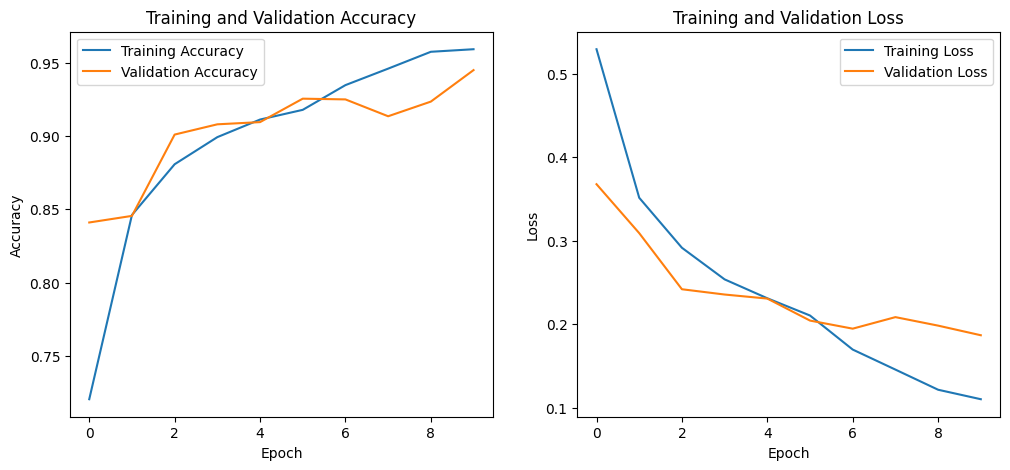

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print("Validation Accuracy: ", val_accuracy)

# Predictions
y_pred = model.predict(X_val)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Classification Report (Precision, Recall, F1-score)
print("Classification Report:")
print(classification_report(y_val, y_pred_classes))

# Plotting training history
def plot_training_history(history):
    # Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)